## Trustpilot review of DK 분석
- Dataset columns info
    - basic info : name, country, review_count(리뷰작성 횟수)
    - review info : writeing date, experience date, title, content, star_rates
- order : 1)EDA 2)Refining dataset

In [118]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

plt.rc("font", family="Malgul Gothic")
sns.set(font="Malgun Gothic",
        rc={"axes.unicode_minus":False},
        style='darkgrid')


today = datetime.today()

# call up the data
file_path = ".\\01.dataset"
file_name = "trustpilot_review_250329.csv"

review_raw= pd.read_csv(os.path.join(file_path,file_name))
# drop useless column
review_raw=review_raw.iloc[:,1:]

In [119]:
# 위에서 만든 국가 코드 → 국가 이름 딕셔너리
country_name_dict = {
    'CO': '콜롬비아', 'MX': '멕시코', 'PT': '포르투갈', 'US': '미국', 'IN': '인도',
    'ES': '스페인', 'GB': '영국', 'AU': '호주', 'DE': '독일', 'SG': '싱가포르',
    'AE': '아랍에미리트', 'PL': '폴란드', 'SK': '슬로바키아', 'SA': '사우디아라비아',
    'CA': '캐나다', 'NZ': '뉴질랜드', 'CL': '칠레', 'IT': '이탈리아', 'FR': '프랑스',
    'MY': '말레이시아', 'TR': '튀르키예', 'BR': '브라질', 'FI': '핀란드', 'NL': '네덜란드',
    'HU': '헝가리', 'PH': '필리핀', 'TH': '태국', 'GR': '그리스', 'SE': '스웨덴',
    'CH': '스위스', 'AT': '오스트리아', 'KR': '대한민국', 'BE': '벨기에', 'IE': '아일랜드',
    'DK': '덴마크', 'RO': '루마니아', 'VN': '베트남', 'PK': '파키스탄', 'HR': '크로아티아',
    'AM': '아르메니아', 'EG': '이집트', 'PE': '페루', 'HK': '홍콩'
}

# 딕셔너리를 이용해 국가 이름 컬럼 추가
review_raw['country_kr'] = review_raw['country'].map(country_name_dict)


In [120]:
# 2. refining datetype data
# 2.1 review_date refine _ removing Updated
review_raw['edit']=None
review_raw['edit']=review_raw['review_date'].str.contains('Updated',na=False)
review_raw['review_date']=review_raw['review_date'].str.replace('Updated ','',regex=False)

# 2.2 Change the formate of datetype date
review_raw['review_date'] = pd.to_datetime(review_raw['review_date'], errors='coerce').dt.strftime('%Y-%m-%d')
review_raw['experience_date'] = pd.to_datetime(review_raw['experience_date'], errors='coerce').dt.strftime('%Y-%m-%d')

# 2.3 drop duplicate
review_raw=review_raw.drop_duplicates(subset=['name','content'],keep='first')

### 0.Fundamental EDA
1. reviewer info
2. star_rate description
3. date description

In [121]:
# 1. reviewer_info _contry
contry_counts= review_raw['country_kr'].value_counts().reset_index(name='user_counts')
contry_rate=review_raw['country_kr'].value_counts(normalize=True).reset_index(name='user_rate')
contry_rate['user_rate']=round(contry_rate['user_rate']*100,2)
pd.merge(contry_counts,contry_rate,on='country_kr').head(10)

,country_kr,user_counts,user_rate
0,미국,66,27.62
1,영국,28,11.72
2,캐나다,16,6.69
3,독일,11,4.60
4,멕시코,10,4.18
5,프랑스,10,4.18
6,싱가포르,8,3.35
7,이탈리아,8,3.35
8,네덜란드,7,2.93
9,호주,7,2.93


In [ ]:
# 결측치 확인
review_raw[review_raw['country_kr'].isna()]

,name,country,review_count,review_date,experience_date,title,content,star_rating,country_kr,edit
105,Millie N,NaN,2,2024-06-25,2024-06-03,Great service great shipping rates,Great service great shipping rates. I got my p...,5,NaN,False


In [122]:
# 2. review_count
reviewr_info = review_raw[['name','review_count']].drop_duplicates().sort_values(by='review_count',ascending=False)
reviewr_info_avg=review_raw.groupby('name')['star_rating'].mean().reset_index(name='star_rating_avg')
pd.merge(reviewr_info,reviewr_info_avg, on='name')

# review count는 자사 리뷰 외 타사 리뷰도 포함한 숫자임을 확인함
    # 해당 데이터 분석에서는 불필요한 정보로 보임

,name,review_count,star_rating_avg
0,Sabrina K.,65,1.0
1,Jules,39,5.0
2,Miracles Follow me,28,4.0
3,Nina Soerensen,26,1.0
4,carol,22,5.0
...,...,...,...
233,Jennilyn Mendoza,1,5.0
234,Leslie Huynh,1,5.0
235,XtineTinayL,1,5.0
236,Juhyun Lee,1,5.0


In [123]:
review_raw['star_rating'].describe()

count    240.000000
mean       4.533333
std        1.101033
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: star_rating, dtype: float64

In [127]:
star_review_summary = review_raw['star_rating'].value_counts(normalize=False).rename('user_counts').to_frame().assign(
    user_rate=lambda df: round(df['user_counts'] / df['user_counts'].sum() * 100, 2)
).reset_index(names='star_rating')
star_review_summary

,star_rating,user_counts,user_rate
0,5,190,79.17
1,4,25,10.42
2,1,16,6.67
3,2,5,2.08
4,3,4,1.67


In [128]:
# 3. Writing date of review
review_raw['review_date'] = pd.to_datetime(review_raw['review_date'], errors='coerce')
review_raw['experience_date'] = pd.to_datetime(review_raw['experience_date'], errors='coerce')

review_raw[['review_date','experience_date']].describe()

,review_date,experience_date
count,240,240
mean,2024-04-20 22:00:00,2024-03-31 07:00:00
min,2022-01-22 00:00:00,2022-01-22 00:00:00
25%,2024-03-18 00:00:00,2024-01-31 18:00:00
50%,2024-06-25 00:00:00,2024-05-25 12:00:00
75%,2024-09-30 12:00:00,2024-09-28 00:00:00
max,2025-03-18 00:00:00,2025-03-18 00:00:00


In [129]:
review_raw['spending_date']=review_raw['review_date']-review_raw['experience_date']
review_raw[review_raw['spending_date']> '30 days'].shape
# 서비스 경험 후 30일이상 경과한 데이터가 서비스 이용에 대해 의미가 있을 것인지, 고민이 필요함

(41, 11)

### 2.Text Mining
- 감정분석(Sentiment Analysis) : 가장 보편적이고, 정성리뷰를 정량적으로 분석할 수 있어서 실무에서 많이 사용됨  
    - [1단계] Data Preprocessing _ 데이터 정제  
        + 소문자 변환, 축약어 복원, 이모지 제거, URL제거, 특수문자 제거, 숫자 제거, 불용어 제거  

    - [2단계] Sentiment Analysis 감정 분석  
        + 사용도구 : VADER (Valence Aware Divtionary and sEntiment Reasoner)

In [130]:
review_raw.columns

Index(['name', 'country', 'review_count', 'review_date', 'experience_date',
       'title', 'content', 'star_rating', 'country_kr', 'edit',
       'spending_date'],
      dtype='object')

#### 2.1 [1단계] Data Preprocessing _ 데이터 정제 

In [131]:
import re
import emoji
import contractions

# 기본 불용어 리스트 직접 정의 (필요시 확장 가능)
custom_stopwords = set([
    'the', 'a', 'an', 'is', 'are', 'am', 'was', 'were', 'be', 'been', 'has', 'have', 'had',
    'this', 'that', 'these', 'those', 'of', 'to', 'in', 'on', 'at', 'for', 'and', 'but', 'or',
    'if', 'then', 'so', 'because', 'as', 'with', 'do', 'does', 'did', 'not', 'no', 'yes', 'i',
    'you', 'he', 'she', 'it', 'we', 'they', 'me', 'my', 'your', 'our', 'their','far', 'th'
])

def clean_text(text):
    if not isinstance(text, str):
        return ''
    
    # 1. 소문자 변환
    text = text.lower()
    
    # 2. 축약어 복원
    text = contractions.fix(text)
    
    # 3. 이모지 제거
    text = emoji.replace_emoji(text, replace='')

    # 4. URL, 이메일 제거
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    
    # 5. 특수문자 제거
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    
    # 6. 숫자 제거
    text = re.sub(r'\d+', '', text)

    # 7. 공백 정리
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 8. 불용어 제거 (custom list)
    tokens = text.split()
    tokens = [word for word in tokens if word not in custom_stopwords]

    return ' '.join(tokens)

In [132]:
# 정제된 텍스트 컬럼 추가
df = review_raw
# 별점 정수형 변환
df['star_rating'] = df['star_rating'].astype(int)
df['title_clean'] = df['title'].apply(clean_text)
df['content_clean'] = df['content'].apply(clean_text)

#### 1차 검수

In [133]:
## (검수1) 전체 리뷰 데이터 확인하기
# pd.set_option('display.max_colwidth', None)
# df.loc[210:240,['content', 'content_clean']]

## (검수2) 정제 전후 비교 하여 변경이 큰 행 찾기
# df['length_diff'] = df.apply(lambda row : abs(len(str(row['content'])) - len(str(row['content_clean']))), axis = 1)

# df.sort_values(by = 'length_diff', ascending=False, inplace=True)
# df[['length_diff','content', 'content_clean']].head(10)

#### 2.2 [2단계] Sentiment Analysis 감정 분석 
1. VADER 분석 : 단어 사전 기반 분석
    - 비교적 분석이 빠르고 설치가 쉬운 반면에, 단어 사전의 뜻에 따라 점수를 매기는 방법이라서, 긍정의 의미를 포함한 단어가 있다면 부정적인 단어가 있음에도 긍정적으로 분석되는 경향이 있음
        + 결과값(score값) : 감정 분석에 따른 감정의 감도에 따른 결과값
2. BERT 분석 : 딥러닝 기반 문맥 분석
    - VADER 분석보다 느리지만 문맥 기반으로 분석함, 단, GPU가 없으면 시간이 오래 걸림
        + 결과값(score값) : 분석한 감정일 확률 (분석후 측정되는 감정이 positive일때, positive로 잘 예측을 했는지에 대한 확률)
        + 참고! : BERT분석은 neutral값이 없음으로 score값이 0.6미만인 경우 중립으로 봄

<중요> 2개의 분석 방식의 결과값(score값)이 의미하는 바가 상이함으로 label(긍정,부정,중립)을 비교함

##### 2.2.1 VADER(베이더) 분석 : - Value Aware Dictionary for Sentiment Reasoning

In [134]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return pd.Series([0.0, 'neutral'])

    score = analyzer.polarity_scores(text)['compound']

    if score >= 0.05:
        label = 'positive'
    elif score <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'

    return pd.Series([score, label])

df[['content_sentiment_score','content_sentiment_label']] = df['content_clean'].apply(get_sentiment)


content_sentiment_label
positive    93.0
negative     4.0
neutral      2.0
Name: proportion, dtype: float64


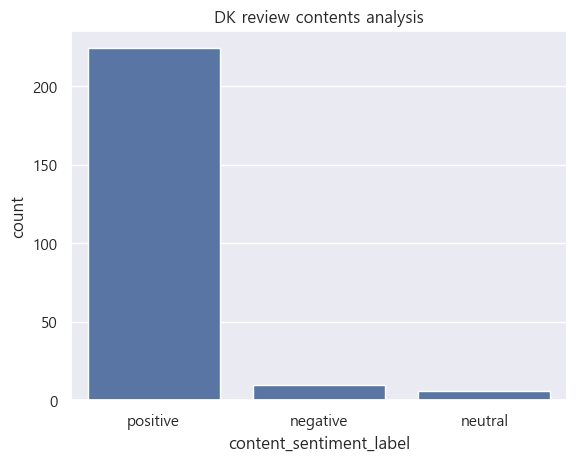

In [135]:
#### (검수3) 1차 분석 확인
print(df['content_sentiment_label'].value_counts(normalize=True).round(2)*100)

import matplotlib.pyplot as plt

sns.countplot(data=df, x='content_sentiment_label', order=list(df['content_sentiment_label'].unique()))
plt.title("DK review contents analysis")
plt.show()

##### 2.2.1-1 VADER 감정분석 튜닝 : 
- star_rating값을 반영하여 sentiment_score값 개선
    + star_rating 분류 :  
        - 1~2 : nagative | 3 : neutral | 4~5 : positive

In [136]:
# star_rating condition
con_pos_rate = df['star_rating']>3
con_nag_rate = df['star_rating']<3
con_neu_rate = df['star_rating']==3

# sentiment_score conditino
con_pos_senti = df['content_sentiment_score'] >= 0.05
con_nag_senti = df['content_sentiment_score'] <= -0.05
con_neu_senti = (df['content_sentiment_score'] < 0.05) & (df['content_sentiment_score'] > -0.05)

In [137]:
# df[con_pos_senti & con_nag_rate][['review_date','star_rating','content','content_clean','content_sentiment_score']] # 9 reviews
df[con_nag_senti & con_pos_rate][['review_date','star_rating','content','content_clean','content_sentiment_score']]#.shape # 1 review

,review_date,star_rating,content,content_clean,content_sentiment_score
226,2022-10-13,5,There was a problem in the customs of my count...,there problem customs country will let shipmen...,-0.4019


In [138]:
def adjust_sentiment(row):
    score = row['content_sentiment_score']
    rating = row['star_rating']
    
    # 보정 강도 설정 (값이 클수록 영향 큼)
    adjustment = 0.95
    
    # 별점이 낮은데 감정 점수가 긍정적인 경우 → 점수 하향
    if rating < 3 and score > 0:
        score -= adjustment
    # 별점이 높은데 감정 점수가 부정적인 경우 → 점수 상향
    elif rating > 3 and score < 0:
        score += adjustment

    # 점수 범위 제한 (-1 ~ 1)
    score = max(min(score, 1.0), -1.0)

    # 조정된 점수에 따라 레이블 재할당
    if score >= 0.05:
        label = 'positive'
    elif score <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'
    
    return pd.Series([score, label])

In [139]:
df[['content_sentiment_score_adj', 'content_sentiment_label_adj']] = df.apply(adjust_sentiment, axis=1)

In [140]:
#### (검수3) 1차 분석 확인
before=df['content_sentiment_label'].value_counts().reset_index(name='before_label(a)')
after_adjustment=df['content_sentiment_label_adj'].value_counts().reset_index(name='after_label(b)')

result_adj= pd.merge(before, after_adjustment,right_on='content_sentiment_label_adj',left_on='content_sentiment_label')
result_adj=result_adj.drop('content_sentiment_label_adj',axis=1)

#result_adj['comparison(b-a)']=result_adj['after_label(b)']-result_adj['before_label(a)']
result_adj['comparison(b-a)']=result_adj.iloc[:,2]-result_adj.iloc[:,1]
result_adj

,content_sentiment_label,before_label(a),after_label(b),comparison(b-a)
0,positive,224,216,-8
1,negative,10,17,7
2,neutral,6,7,1


In [141]:
# df[con_nag_senti & con_pos_rate][['review_date','star_rating','content','content_clean','content_sentiment_score','content_sentiment_score_adj','content_sentiment_label_adj']]#.shape # 1 review
#df[con_pos_senti & con_nag_rate][['review_date','star_rating','content','content_clean','content_sentiment_score','content_sentiment_score_adj','content_sentiment_label_adj']] # 9 reviews

##### 2.2.1-2 감정분석 상관관계 분석 : star_rating와 sentiment_score의 상관관계 분석

In [142]:
before_corr_value = df['content_sentiment_score'].corr(df['star_rating'])
after_corr_value = df['content_sentiment_score_adj'].corr(df['star_rating'])
print(f"감정 점수와 별점의 상관계수 \n 튜닝 전 : {round(before_corr_value, 3)} \n 튜닝 후 : {round(after_corr_value, 3)}")

감정 점수와 별점의 상관계수 
 튜닝 전 : 0.571 
 튜닝 후 : 0.801


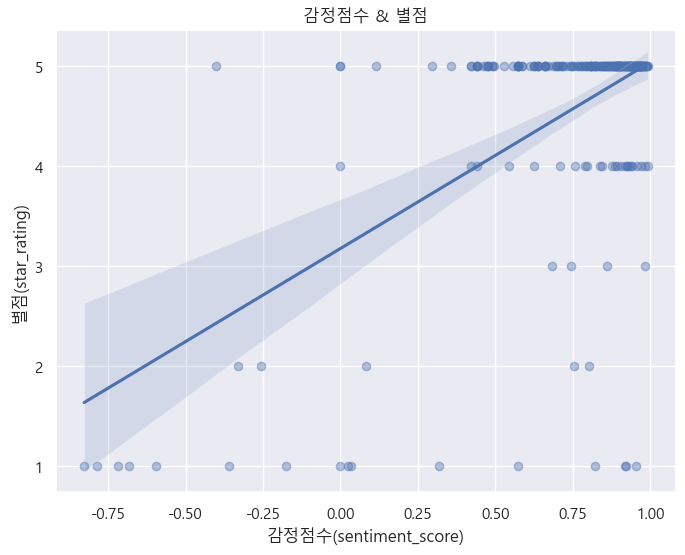

In [143]:
plt.figure(figsize=(8,6))
sns.regplot(data=df, x='content_sentiment_score',y='star_rating', #regplot : 산점도와 회귀선을 그려주는 시각화 함수
            scatter_kws={'alpha':0.4}) #산점도의 점의 속성 조절 투명도를 설정하는 매개변수
plt.title("감정점수 & 별점")
plt.xlabel("감정점수(sentiment_score)")
plt.ylabel("별점(star_rating)")
plt.grid(True) # 그래프에 격자추가
plt.show()

##### 2.2.2 BERT(버트)분석

In [144]:
from transformers import pipeline
from tqdm import tqdm

# 감정 분석 파이프라인 생성
sentiment_pipeline = pipeline("sentiment-analysis")
# Check the procession with tqdm
def get_bert_sentiment(texts):
    results = []
    for text in tqdm(texts):
        if not isinstance(text, str) or text.strip() == "":
            results.appent({"label": "neutural", "score": 0.0})
        else:
            try:
                result = sentiment_pipeline(text[:512])[0]
                results.append(result)
            except:
                results.append({"label": "neutural", "score": 0.0})
    return results

# 감정 분석 결과 적용
bert_results = get_bert_sentiment(df['content'])

# result
df['bert_sentiment_label'] = [r['label'] for r in bert_results]
df['bert_sentiment_score'] = [r['score'] for r in bert_results]

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
100%|██████████| 240/240 [00:24<00:00,  9.92it/s]


In [145]:
# 함수 _ label값에 neutral 값 추가
def convert_bert_label(label, score, threshold=0.6):
    if score < threshold:
        return 'neutral'
    elif label.upper() == 'POSITIVE':
        return 'positive'
    else:
        return 'negative'

# label값에 neutral 값 추가   
df['bert_sentiment_label_adj'] = df.apply(lambda x: convert_bert_label(x['bert_sentiment_label'],x['bert_sentiment_score']),axis=1)

bert_sentiment_label_adj
positive    83.0
negative    16.0
neutral      1.0
Name: proportion, dtype: float64


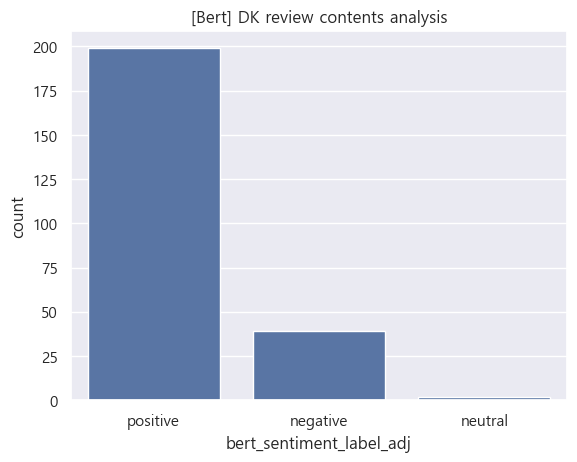

In [146]:
#### (검수4) 2차 분석 확인
print(df['bert_sentiment_label_adj'].value_counts(normalize=True).round(2)*100)

sns.countplot(data=df, x='bert_sentiment_label_adj', order=list(df['bert_sentiment_label_adj'].unique()))
plt.title("[Bert] DK review contents analysis")
plt.show()

In [ ]:
# vader vs bert 분류 결과 비교 (수적 비교)
vader = df.groupby('content_sentiment_label_adj')['name'].count().reset_index(name='vader_result')
bert = df.groupby('bert_sentiment_label_adj')['name'].count().reset_index(name='bert_result')

result = pd.merge(vader.set_index('content_sentiment_label_adj'),
                  bert.set_index('bert_sentiment_label_adj'),
                  left_index=True, right_index=True,how='outer')
result.sort_values(by='vader_result',ascending=False)

,vader_result,bert_result
content_sentiment_label_adj,,
positive,216,199
negative,17,39
neutral,7,2


In [153]:
# vader vs bert 분류 결과 비교 (분석 후 결과 값 비교)
df['comparision_VB'] = df['content_sentiment_label_adj']==df['bert_sentiment_label_adj']
match_rate=df['comparision_VB'].mean()

print(f"Vader & Bert 감정일치율 비교 : {round(match_rate*100)}(%)")

Vader & Bert 감정일치율 비교 : 88(%)


In [155]:
df[df['comparision_VB']==False][['content','star_rating','content_sentiment_label_adj','bert_sentiment_label_adj','comparision_VB']]

,content,star_rating,content_sentiment_label_adj,bert_sentiment_label_adj,comparision_VB
5,"So far so good, but we're only at the purchasi...",4,positive,negative,False
8,I have used delivered korea 4 times in 2024 fo...,5,neutral,negative,False
15,Ive been ordering items from Korea (Bunjang) v...,4,positive,negative,False
19,I've been using Delivered Korea for close to 2...,5,positive,negative,False
37,Communication DEFINITELY needs work!I put in a...,3,positive,negative,False
46,"They are the best proxy I have ever used, and ...",5,positive,negative,False
80,I have used this service to purchase. I enjoy ...,4,positive,negative,False
85,"Good k-addy experience, but the consolidation ...",5,positive,negative,False
92,Trustworthy proxy. I didn't appreciate much ho...,3,positive,negative,False
100,"It's been a week and a half, and my issue is s...",2,negative,positive,False


In [ ]:
##### (검수5) Vader vs Bert 의 실제 평가와 일치여부 with Star_rating
def label_from_star(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['star_sentiment_label'] = df['star_rating'].apply(label_from_star)

# 각각 비교
df['vader_correct'] = df['content_sentiment_label'] == df['star_sentiment_label']
df['vader_adj_correct'] = df['content_sentiment_label_adj'] == df['star_sentiment_label']
df['bert_correct'] = df['bert_sentiment_label_adj'] == df['star_sentiment_label']

# 정확도 비교
print(f"✅ VADER 정확도(튜닝 전): {df['vader_correct'].mean():.2%}")
print(f"✅ VADER 정확도(튜닝 후): {df['vader_adj_correct'].mean():.2%}")
print(f"✅ BERT 정확도: {df['bert_correct'].mean():.2%}")

✅ VADER 정확도(튜닝 전): 91.67%
✅ VADER 정확도(튜닝 후): 95.42%
✅ BERT 정확도: 90.00%


#### 감정분석(Sentiment-analyses)
Vader & Bert분석을 모두 진행한 결과, Trustpilot의 Delivered Korea Review 데이터는 <b>Vader 분석후 별점을 반영하여 튜닝을 했을 때, 더 높은 정확도를 보임</b>  
    - 일반적인 Vader분석이 리뷰의 감정을 100% 완벽하게 분석하지 못하여, 별점에 따라 감정 결과를 조정했을 때 높은 정확도를 보였음.  

### 3. 시간 경과에 따른 감성 트랜드 분석

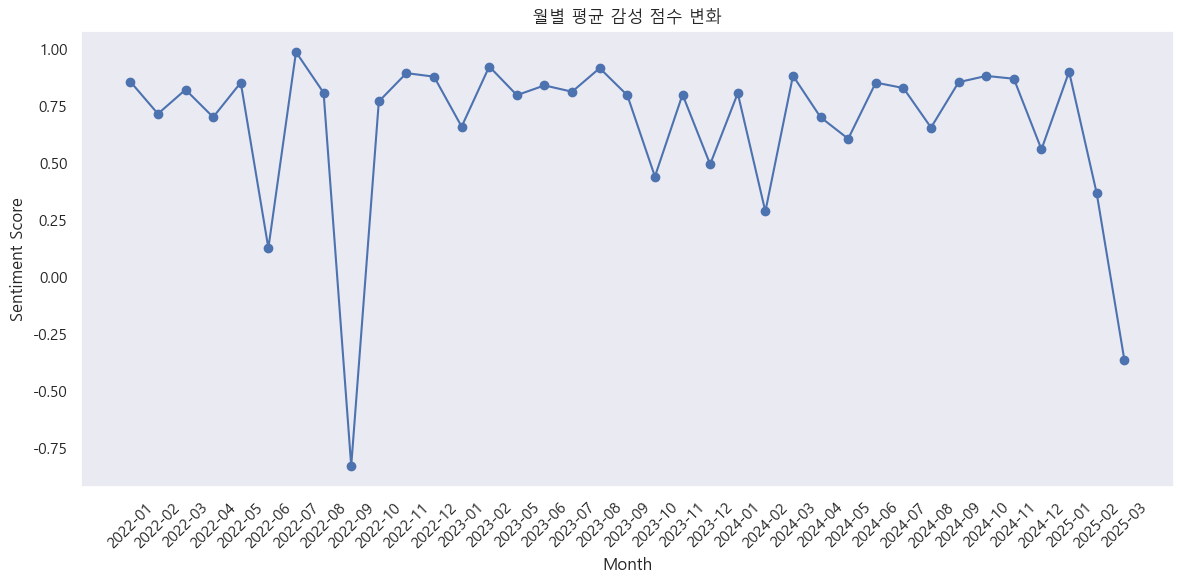

In [164]:
# 연/월 기준 그룹화
df['year_month'] = df['review_date'].dt.to_period('M')
trend = df.groupby('year_month')['content_sentiment_score_adj'].median().reset_index()

# 시각화 (추후 활용 가능)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(trend['year_month'].astype(str), trend['content_sentiment_score_adj'], marker='o')
plt.title('월별 평균 감성 점수 변화')
plt.xlabel('Month')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


### 4. 고객 니즈 분석 _ 리뷰 워드 클라우드 제작

In [166]:
df.columns

Index(['name', 'country', 'review_count', 'review_date', 'experience_date',
       'title', 'content', 'star_rating', 'country_kr', 'edit',
       'spending_date', 'title_clean', 'content_clean',
       'content_sentiment_score', 'content_sentiment_label',
       'content_sentiment_score_adj', 'content_sentiment_label_adj',
       'bert_sentiment_label', 'bert_sentiment_score',
       'bert_sentiment_label_adj', 'comparision_VB', 'star_sentiment_label',
       'vader_correct', 'bert_correct', 'vader_adj_correct', 'year_month'],
      dtype='object')

In [170]:
from sklearn.feature_extraction.text import CountVectorizer

# 키워드 빈도 추출
vectorizer = CountVectorizer(stop_words='english', max_features=30)
X = vectorizer.fit_transform(df['content_clean'])
keywords = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
keywords.drop(['korea','delivered'],axis=1, inplace=True)
# 상위 키워드
top_keywords = keywords.sum().sort_values(ascending=False)
print("📌 고객이 DK에게 자주 언급한 키워드:\n", top_keywords.head(10))


📌 고객이 DK에게 자주 언급한 키워드:
 service     183
shipping    113
use          81
using        79
buy          68
great        67
easy         66
package      65
items        63
customer     62
dtype: int64


📌 고객이 DK에게 자주 언급한 키워드:
 service       183
buy            68
great          67
easy           66
package        65
items          63
customer       62
time           62
packages       59
used           57
fast           56
services       54
good           51
recommend      48
order          41
really         38
experience     32
quick          31
love           31
bunjang        31
dtype: int64


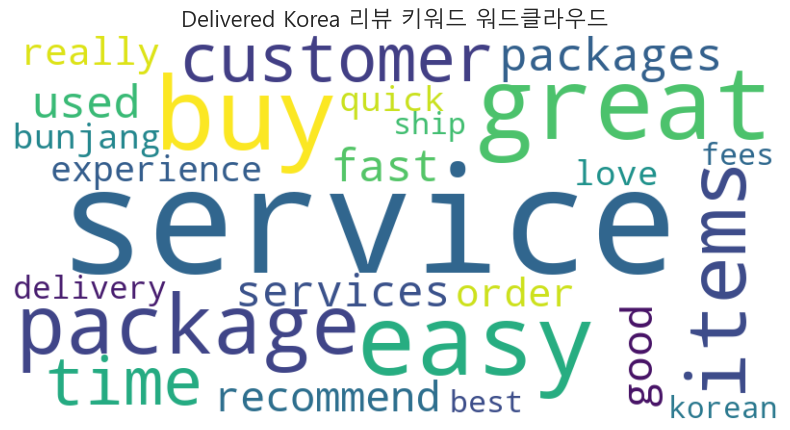

In [176]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# 1. 키워드 빈도 추출
vectorizer = CountVectorizer(stop_words='english', max_features=30)
X = vectorizer.fit_transform(df['content_clean'])

# 2. 키워드 DataFrame
keywords = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# 3. 특정 키워드 제거
keywords.drop(['korea','delivered','use','using','shipping'], axis=1, inplace=True, errors='ignore')

# 4. 상위 키워드 집계
top_keywords = keywords.sum().sort_values(ascending=False)

print("📌 고객이 DK에게 자주 언급한 키워드:\n", top_keywords.head(20))

# 5. 워드클라우드 시각화
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(top_keywords)

# 6. 출력
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Delivered Korea 리뷰 키워드 워드클라우드", fontsize=16)
plt.show()


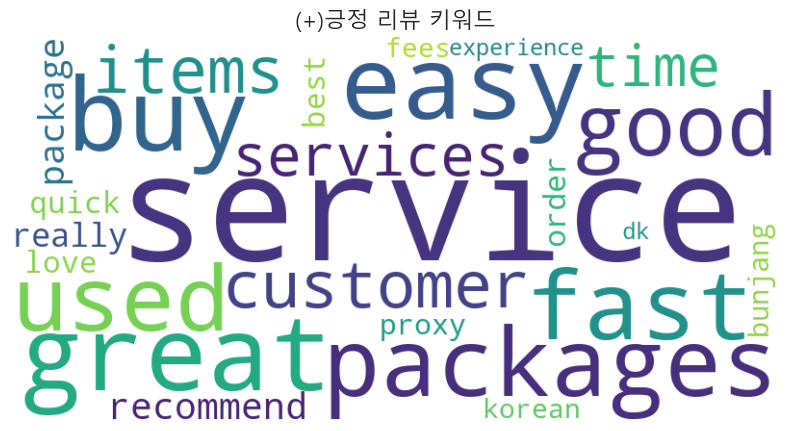

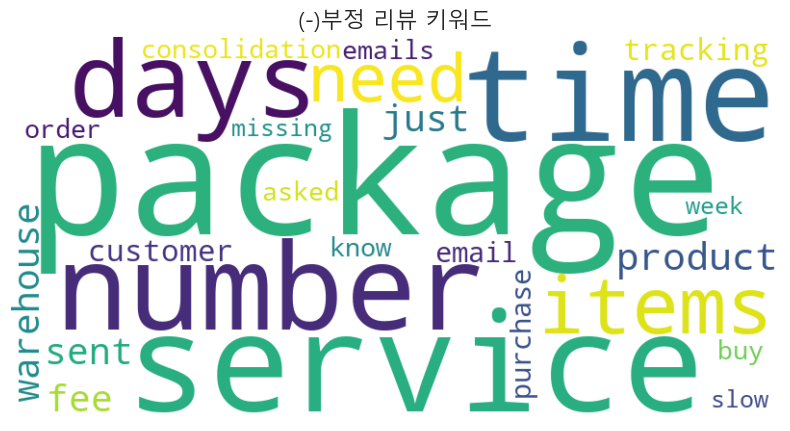

In [196]:
#### 4.2 긍정/부정 리뷰 분리하여 워드클라우드 생성
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# 1. 긍정/부정 텍스트 분리 (예: BERT 기준)
positive_texts = df[df['content_sentiment_label_adj'] == 'positive']['content_clean']
negative_texts = df[df['content_sentiment_label_adj'] == 'negative']['content_clean']

# 2. 벡터화 함수 정의
def get_top_keywords(text_series, max_words=30):
    vectorizer = CountVectorizer(stop_words='english', max_features=max_words)
    X = vectorizer.fit_transform(text_series)
    keywords = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    keywords.drop(columns=['korea','delivered','use','using','shipping'], errors='ignore', inplace=True)
    top_keywords = keywords.sum().sort_values(ascending=False)
    return top_keywords

# 3. 워드클라우드 생성 함수 정의
def show_wordcloud(freq, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate_from_frequencies(freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# 4. 각각 분석 & 시각화
positive_keywords = get_top_keywords(positive_texts)
negative_keywords = get_top_keywords(negative_texts)

show_wordcloud(positive_keywords, "(+)긍정 리뷰 키워드")
show_wordcloud(negative_keywords, "(-)부정 리뷰 키워드")


#### 5. 부정리뷰 추가 분석으로 인사이트 도출

In [193]:
# 부정 리뷰만 필터링
negative_reviews = df[df['content_sentiment_label_adj'] == 'negative']['content_clean']

# 키워드 추출
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=50)
X = vectorizer.fit_transform(negative_reviews)

# 키워드별 빈도 계산
neg_keywords = pd.Series(X.toarray().sum(axis=0), index=vectorizer.get_feature_names_out()).sort_values(ascending=False)
print("❗ 부정 리뷰에서 자주 언급된 키워드:\n")
print(neg_keywords.head(20))

❗ 부정 리뷰에서 자주 언급된 키워드:

shipping     18
package      18
service      12
number       11
days         11
time         11
items         9
need          8
product       8
just          7
korea         7
customer      7
fee           7
sent          7
warehouse     7
using         7
tracking      7
email         6
purchase      6
week          5
dtype: int64


In [197]:
issue_dict = {
    '배송지연/배송이슈': [
        'shipping', 'delivery', 'shipped', 'ship',
        'time', 'days', 'times', 'order', 'tracking'
    ],
    '상품누락/품질/오배송': [
        'package', 'packages', 'item', 'items', 'product', 'number',
        'issue', 'purchasing', 'purchase', 'buy', 'make'
    ],
    '물류창고/보관': [
        'warehouse', 'lot', 'proxy', 'bunjang', 'korea'
    ],
    '과금/요금 이슈': [
        'fee', 'fees', 'pay', 'used'
    ],
    '고객응대/CS': [
        'email', 'emails', 'reply', 'asked', 'say', 'sent', 'know',
        'company', 'customer', 'services', 'service', 'support'
    ],
    '사용경험/UX': [
        'use', 'using', 'just', 'good', 'experience', 'easy', 'like', 'recommend'
    ],
}

# 빈도 기준 키워드 상위 30개만 사용
top_neg_keywords = neg_keywords.head(30)

# 이슈 카테고리별 집계
issue_summary = {}

for category, keywords in issue_dict.items():
    total = sum([top_neg_keywords.get(word, 0) for word in keywords])
    issue_summary[category] = total

# 결과 정렬
issue_summary = pd.Series(issue_summary).sort_values(ascending=False)
print("\n📌 부정 리뷰의 주요 개선 필요 요소:\n")
print(issue_summary)



📌 부정 리뷰의 주요 개선 필요 요소:

상품누락/품질/오배송    57
배송지연/배송이슈      52
고객응대/CS        47
사용경험/UX        19
물류창고/보관        14
과금/요금 이슈        7
dtype: int64


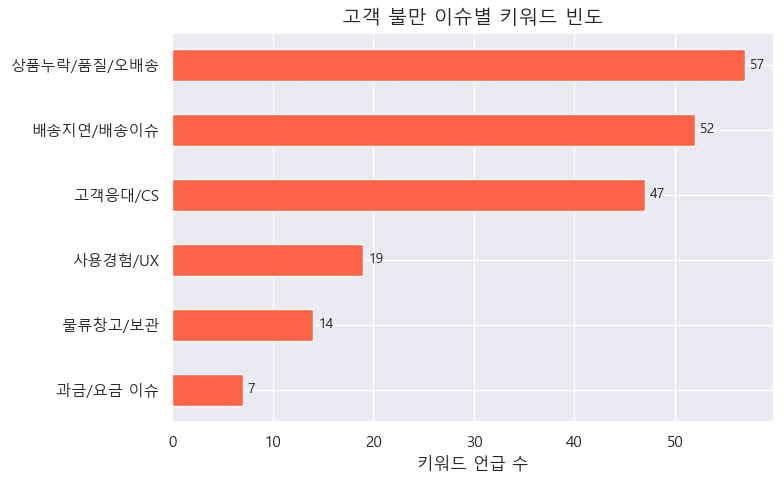

In [198]:
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(8, 5))
ax = issue_summary.plot(kind='barh', color='tomato')

plt.title('고객 불만 이슈별 키워드 빈도', fontsize=14)
plt.xlabel('키워드 언급 수')

# y축 뒤집기 (상위가 위로)
plt.gca().invert_yaxis()

# 막대 옆에 숫자 표시
for i, (value, label) in enumerate(zip(issue_summary.values, issue_summary.index)):
    plt.text(value + 0.5, i, str(int(value)), va='center', fontsize=10)

plt.tight_layout()
plt.show()


#### 6. 나라별 부정 리뷰 분석

In [ ]:
df[df['content_sentiment_label_adj']=='positive'].groupby('country_kr').agg(
    reviewer_count=('name', 'count'),
    star_rating_avg=('star_rating', 'mean')
).sort_values(by='reviewer_count', ascending=False)

,reviewer_count,star_rating_avg
country_kr,,
미국,59,4.796610
영국,23,4.869565
캐나다,16,4.687500
독일,11,4.909091
프랑스,10,4.900000
멕시코,9,4.666667
이탈리아,8,4.750000
네덜란드,6,4.666667
싱가포르,6,4.833333


In [250]:
df[df['content_sentiment_label_adj']=='negative'].groupby('country_kr').agg(
    reviewer_count=('name', 'count'),
    star_rating_avg=('star_rating', 'mean')
).sort_values(by='reviewer_count', ascending=False)

,reviewer_count,star_rating_avg
country_kr,,
미국,5,1.6
영국,3,1.0
싱가포르,2,1.0
멕시코,1,1.0
스페인,1,2.0
벨기에,1,1.0
오스트리아,1,1.0
포르투갈,1,1.0
호주,1,2.0


In [226]:
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer

# 전체 국가 리스트
countries = df['country_kr'].dropna().unique()

# 결과 저장 딕셔너리
country_issue_summary = {}

# 국가별 분석
for country in countries:
    neg_texts = df[
        (df['content_sentiment_label_adj'] == 'negative') &
        (df['country_kr'] == country)
    ]['content_clean']
    
    if len(neg_texts) < 1:
         continue  # 데이터 수가 너무 적은 국가는 제외 하려고 하였으나 부정적인 리뷰 수가 적으로 모두 포함하여 분석

    # 키워드 추출
    vectorizer = CountVectorizer(stop_words='english', max_features=50)
    X = vectorizer.fit_transform(neg_texts)
    keywords = pd.Series(X.toarray().sum(axis=0), index=vectorizer.get_feature_names_out())

    # 이슈별 키워드 매핑
    issue_counts = {}
    for issue, word_list in issue_dict.items():
        total = sum([keywords.get(w, 0) for w in word_list])
        issue_counts[issue] = total
    
    # 저장
    country_issue_summary[country] = issue_counts

In [ ]:
# 데이터프레임으로 변환
country_issue_df = pd.DataFrame(country_issue_summary).T.fillna(0).astype(int)
country_issue_df = country_issue_df.sort_index()
country_issue_df['sum'] = country_issue_df.sum(axis=1)

# 열별 합계 계산
total_row = pd.DataFrame(country_issue_df.sum()).T

# 인덱스 이름 지정 (예: '합계')
total_row.index = ['합계']

# 기존 df에 합계 행 추가
country_issue_df_with_total = pd.concat([country_issue_df, total_row])

# 확인



In [ ]:
country_issue_df_with_total.sort_values(by='sum',ascending=False)

,배송지연/배송이슈,상품누락/품질/오배송,물류창고/보관,과금/요금 이슈,고객응대/CS,사용경험/UX,sum
합계,55,64,17,14,56,27,233
미국,29,42,10,7,18,6,112
영국,7,8,2,5,15,10,47
싱가포르,8,4,1,1,4,5,23
포르투갈,4,4,0,1,6,2,17
스페인,4,4,1,0,3,1,13
벨기에,2,1,3,0,3,2,11
오스트리아,0,1,0,0,4,1,6
호주,0,0,0,0,2,0,2
멕시코,0,0,0,0,1,0,1


C:\Users\damla\AppData\Local\Temp\ipykernel_9668\987827266.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\damla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


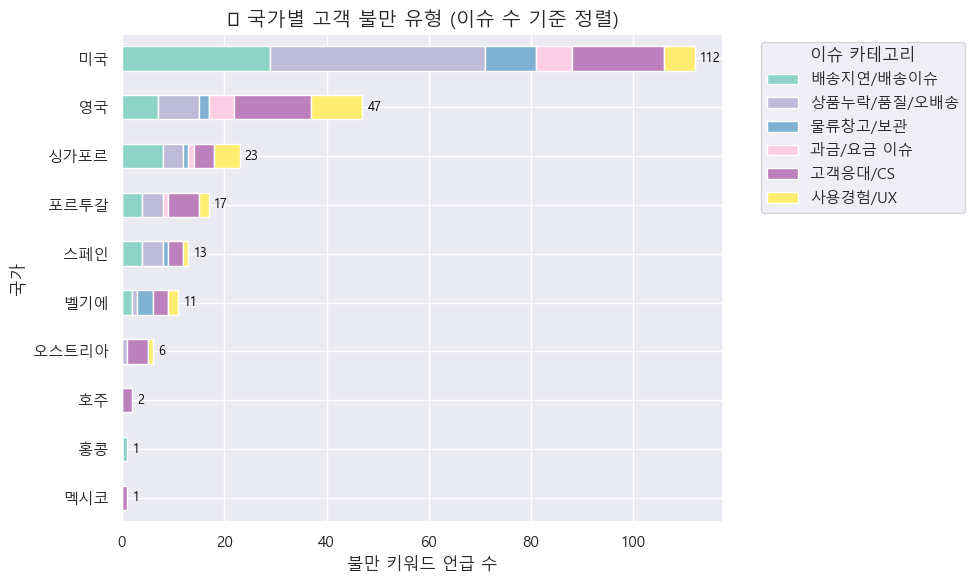

In [253]:
import matplotlib.pyplot as plt

# 1. Remove '합계' row and 'sum'/'Total' columns
plot_df = country_issue_df_with_total.drop(index='합계', errors='ignore')
plot_df = plot_df.drop(columns=['sum', 'Total'], errors='ignore')

# 2. Sort by total number of issue mentions (row sum)
plot_df = plot_df.loc[plot_df.sum(axis=1).sort_values(ascending=True).index]

# 3. Plot stacked horizontal bar chart
ax = plot_df.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='Set3')

# 4. Add total value labels on the bars
for i, (index, row) in enumerate(plot_df.iterrows()):
    total = row.sum()
    ax.text(total + 1, i, str(int(total)), va='center', fontsize=9, color='black')

# 5. Final touches
plt.title("📊 국가별 고객 불만 유형 (이슈 수 기준 정렬)", fontsize=14)
plt.xlabel("불만 키워드 언급 수")
plt.ylabel("국가")
plt.legend(title="이슈 카테고리", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()
